[link text](https://)##Assignment 3 Naïve Bayes and Sentiment Classification and Logistic Regression
Instructions
* Read the following Chapter 4: Naive Bayes and Sentiment Classification. Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright © 2021. All rights reserved. Draft of September 21, 2021. I have tried to pull out relevant notes for you below, but it is encouraged that you read each chapter provided.
* Read the following Chapter 5: Logistic Regression. Speech and Language Processing. Daniel Jurafsky & James H. Martin. Copyright © 2021. All rights reserved. Draft of September 21, 2021. I have tried to pull out relevant notes for you below, but it is encouraged that you read each chapter provided.

Summary
Classification is one of the most important tasks of NLP and in machine learning. In NLP it often means the task of text categorization for both sentiment analysis, spam detection, and topic modeling. Naïve Bayes is often one of the first classification algorithms defined in NLP.  The intuition behind a classifier is lies at the underlying probability inferred by the Bayesian Inference, which uses Baye’s rule and conditional probabilities.

Here’s a reminder on Baye’s Rule:
P(y)=P(x)P(x)/(P(y))

We are saying “what is the probability of x given y”. Naïve Bayes is a generative model because there is an input that helps the model determine what the output could be. Said differently, “to train a generative model we first collect a large amount of data in some domain (e.g., think millions of images, sentences, or sounds, etc.) and then train a model to generate data like it.” [6]

So in the case of Naïve Bayes, we say given some word, what should be the class of the current word we are assessing? Contrastingly, discriminative models such as logistic regression, learn from features provided to the algorithm and then determine or predict what the class is. [7]


With Naïve Bayes, the assumption is that the probabilities are independent. We often call the Naïve Bayes classifier the bag-of-words approach. That’s because we are essentially throwing in the collection of words into a ‘bag’, selecting a word at random, and then calculating their frequency to use in the Bayesian Inference. Thus, context – the position of words -- is ignored and despite this, it turns out that the Naïve Bayes approach can be accurate and effective at determining whether an email is spam for example.

Back to bag of words. With bag of words, we assume that the position of the words are not relevant -- that dependency or context in the word phrase or sentence doesn’t matter. Relatedly, the naive Bayes assumption implies that the conditional probabilities are independent -- a rather strange assumption to make for words in a sentence! The equation for the naive Bayes classifier is outlined below:

You can use Naive Bayes by creating an index of words and walking through every word position in a test or corpus.


It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.

For this Assignment, you can start with a spam/ham dataset, then predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).   One example corpus:   https://spamassassin.apache.org/old/publiccorpus/

You may work alone or in a group on this project.  You're welcome to use any tools or approach that you like.  Due before our next meetup. Starter code provided below.

Test example is provided at the end.

Libraries you may wish to use

In [1]:
import pandas as pd
import numpy as np
import os
from os import makedirs, path, remove, rename, rmdir
from tarfile import open as open_tar
from shutil import rmtree
from urllib import request, parse
from glob import glob
from os import path
from re import sub
from email import message_from_file
from glob import glob
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict
from functools import partial
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score)
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
import gc

download corpus using the following functions

Note: you may need to mount your drive on google then run this location. See previous exercises.

In [2]:
def download_corpus(dataset_dir: str = 'data'):
    base_url = 'https://spamassassin.apache.org'
    corpus_path = 'old/publiccorpus'
    files = {
        '20021010_easy_ham.tar.bz2': 'ham',
        '20021010_hard_ham.tar.bz2': 'ham',
        '20021010_spam.tar.bz2': 'spam',
        '20030228_easy_ham.tar.bz2': 'ham',
        '20030228_easy_ham_2.tar.bz2': 'ham',
        '20030228_hard_ham.tar.bz2': 'ham',
        '20030228_spam.tar.bz2': 'spam',
        '20030228_spam_2.tar.bz2': 'spam',
        '20050311_spam_2.tar.bz2': 'spam' }

    #creates the folders: downloads, ham and spam
    downloads_dir = path.join(dataset_dir, 'downloads')
    ham_dir = path.join(dataset_dir, 'ham')
    spam_dir = path.join(dataset_dir, 'spam')

    makedirs(downloads_dir, exist_ok=True)
    makedirs(ham_dir, exist_ok=True)
    makedirs(spam_dir, exist_ok=True)


    for file, spam_or_ham in files.items():
        # download files from URL of each specific .bz2 file
        url = parse.urljoin(base_url, f'{corpus_path}/{file}')
        tar_filename = path.join(downloads_dir, file)
        request.urlretrieve(url, tar_filename)

        #list e-mails in the compressed .bz2 file
        emails = []
        with open_tar(tar_filename) as tar:
            tar.extractall(path=downloads_dir)
            for tarinfo in tar:
                if len(tarinfo.name.split('/')) > 1:
                    emails.append(tarinfo.name)

        # move e-mails to ham or spam directory
        for email in emails:
            directory, filename = email.split('/')
            directory = path.join(downloads_dir, directory)

            if not path.exists(path.join(dataset_dir, spam_or_ham, filename)):
                rename(path.join(directory, filename),
                   path.join(dataset_dir, spam_or_ham, filename))

        rmtree(directory)

download_corpus()

#How many e-mails are classified in our dataset as either Spam or not Spam?


In [3]:
#How many e-mails are classified in our dataset as either Spam or not Spam?
ham_dir = path.join('data', 'ham')
spam_dir = path.join('data', 'spam')

print('Number of Non-Spam E-mails:', len(glob(f'{ham_dir}/*')))
print('\nNumber of Spam E-mails:', len(glob(f'{spam_dir}/*')))

Number of Non-Spam E-mails: 6952

Number of Spam E-mails: 2399


Provide your classifier below

In [4]:
##### START CODE ###
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

hamtext, spamtext=[],[]
for i in range(len(os.listdir(ham_dir))):
  #print(os.listdir(ham_dir)[i])
  file=open(ham_dir+"/"+os.listdir(ham_dir)[i], "r", encoding='windows-1252')
  hamtext.append(file.read())
  file.close

for i in range(len(os.listdir(spam_dir))):
  #print(os.listdir(ham_dir)[i])
  file=open(spam_dir+"/"+os.listdir(spam_dir)[i], "r", encoding='cp437')
  spamtext.append(file.read())
  file.close

nltk.download('stopwords')
stopwords_Eng = stopwords.words('english')
stemmer = PorterStemmer()
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)

# Data Preprocessing
def preprocess(data):
  data=data.lower()
  remove_1 = '\n'
  regex_remove_hyperlinks = 'https?:[/\.\w]+'
  regex_remove_email = '[\w.]+@[\w. ]+'
  data = re.sub(remove_1, '',data)
  data = re.sub(regex_remove_hyperlinks, '',data)
  data = re.sub(regex_remove_email, '',data)
  tokenized_s = tokenizer.tokenize(data)
  cleaned_s=[i for i in tokenized_s if i not in stopwords_Eng and i not in string.punctuation]
  stem_s = [stemmer.stem(i) for i in cleaned_s]
  return ' '.join(stem_s)

clean_ham = [preprocess(i) for i in hamtext]
clean_spam = [preprocess(i) for i in spamtext]

df = pd.DataFrame(list(zip(clean_ham+clean_spam, [0]*len(clean_ham)+[1]*len(clean_spam))),columns=['text','label'])
df=df.sample(frac=1) # shuffuling

# Data Spliting
train = df.iloc[:int(df.shape[0]*0.8),:]
test = df.iloc[int(df.shape[0]*0.8):,:]

print('training set',train.shape,'\n')
print('testing set',test.shape,'\n')
print('training data has:')
print(train.groupby('label').count(),'\n')
print('testing data has:')
print(test.groupby('label').count(),'\n')

X_train, X_test, y_train, y_test = train['text'], test['text'], train['label'].values, test['label'].values

# Training
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
classifier = MultinomialNB()
classifier.fit(X_train_counts, y_train)
X_test_counts = vectorizer.transform(X_test)
predictions = classifier.predict(X_test_counts)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, predictions, pos_label=1)
print("F1 Score:", f1)

# Calculate precision
precision = precision_score(y_test, predictions, pos_label=1)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test, predictions, pos_label=1)
print("Recall:", recall)

#### END CODE ####

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


training set (7480, 2) 

testing set (1871, 2) 

training data has:
       text
label      
0      5553
1      1927 

testing data has:
       text
label      
0      1399
1       472 

Accuracy: 0.9700694815606627
F1 Score: 0.9381898454746137
Precision: 0.9792626728110599
Recall: 0.9004237288135594


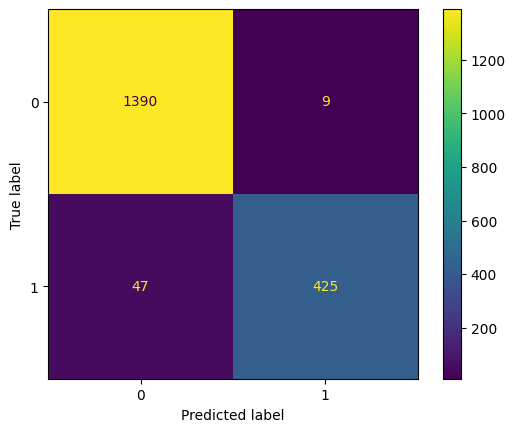

In [9]:
# Showing the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier.classes_)
disp.plot()
plt.show()


The following email is a test email. You can take this and test your classifier to see if it predicts spam or not.



In [ ]:
spam_email = """
Subject: Get Rich Quick!

Dear Friend,

Congratulations! You've been selected to participate in an exclusive opportunity to make thousands of dollars from the comfort of your own home. Our revolutionary system guarantees quick and easy cash with minimal effort.

No more struggling to pay bills or worrying about financial security. With our proven method, you can start earning massive amounts of money in no time.

Here's what some of our satisfied customers have to say:
- "I was skeptical at first, but I'm now living my dream life thanks to this incredible system!" - John S.
- "I never thought making money online could be this simple. It's changed my life!" - Sarah L.

Don't miss out on this limited-time offer. Act now to secure your spot and start enjoying a life of financial freedom.

Click the link below to get started:
www.getrichquick.com

Remember, this opportunity is exclusive and won't last long. Take control of your financial future today!

Best regards,
The Get Rich Quick Team
"""


In [ ]:
X_test_counts = vectorizer.transform([spam_email])
if classifier.predict(X_test_counts)==1:
  print('This mail is spam')
else:
  print('This mail is ham')

This mail is spam
